# NEURAL NETWORK OBJECT RECOGNITION

## PROJECT

UoEO Machine Learning

Assignment Due Date: 20 January, 2025

## AUTHOR

Maria Ingold

## PROJECT DESCRIPTION

Your ML model should address following points:
1. Introduction: Introduce CIFAR-10 and perform basic Exploratory Data Analysis (EDA)
2. Partition and Validation: Method to partition the validation set from the training data, insights into metadata, importance of separate validation.
3. Artificial Neural Network Architecture: Elaborate.
4. Activation Function: What and why selected.
5. Loss Function: Describe what and why implemented.
6. Epochs and Batch Size: Number and why.
7. Evalution: Insights on Neural Network design elements strategy.
8. Conclusion: Reflections on learnings acquired.


## IMPORT LIBRARIES

In [17]:
import numpy as np                            # numerical computation
import matplotlib.pyplot as plt               # Plots
import tensorflow as tf                       # machine learning
from tensorflow.keras.datasets import cifar10 # CIFAR-10 dataset
from sklearn.model_selection import train_test_split # train test split

## LOAD DATASET

CIFAR-10 (Krizhevsky, 2009)
- 60,000 32x32 colour images
- 10 classes, 6000 images per class
- 50,000 training
- 10,000 testing



In [12]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

## EXPLORATORY DATA ANALYSIS (EDA)

### Shape

- Training data shape: 50,000 images of 32x32 size x 3 (RGB = Red Green Blue)
- Training labels: 50,000 labels of just one name
- Training data shape: 10,000 images of 32x32 size x 3 (RGB = Red Green Blue)
- Testing lables shape: 10,000 labels of just one name

In [13]:
# Inspect the shape of the data
print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing data shape: {x_test.shape}")
print(f"Testing labels shape: {y_test.shape}")

Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Testing data shape: (10000, 32, 32, 3)
Testing labels shape: (10000, 1)


### Constant
- class names as mapped by CIFAR-10
- 10 classes map to the following:
- 0 = airplane
- 1 = automobile
- 2 = bird
- 3 = cat
- 4 = deer
- 5 = dog
- 6 = frog
- 7 = horse
- 8 = ship
- 9 = truck


In [14]:
LABEL_NAMES = ['airplane', 'automobile','bird','cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### Visualise

- Ten random images per label name

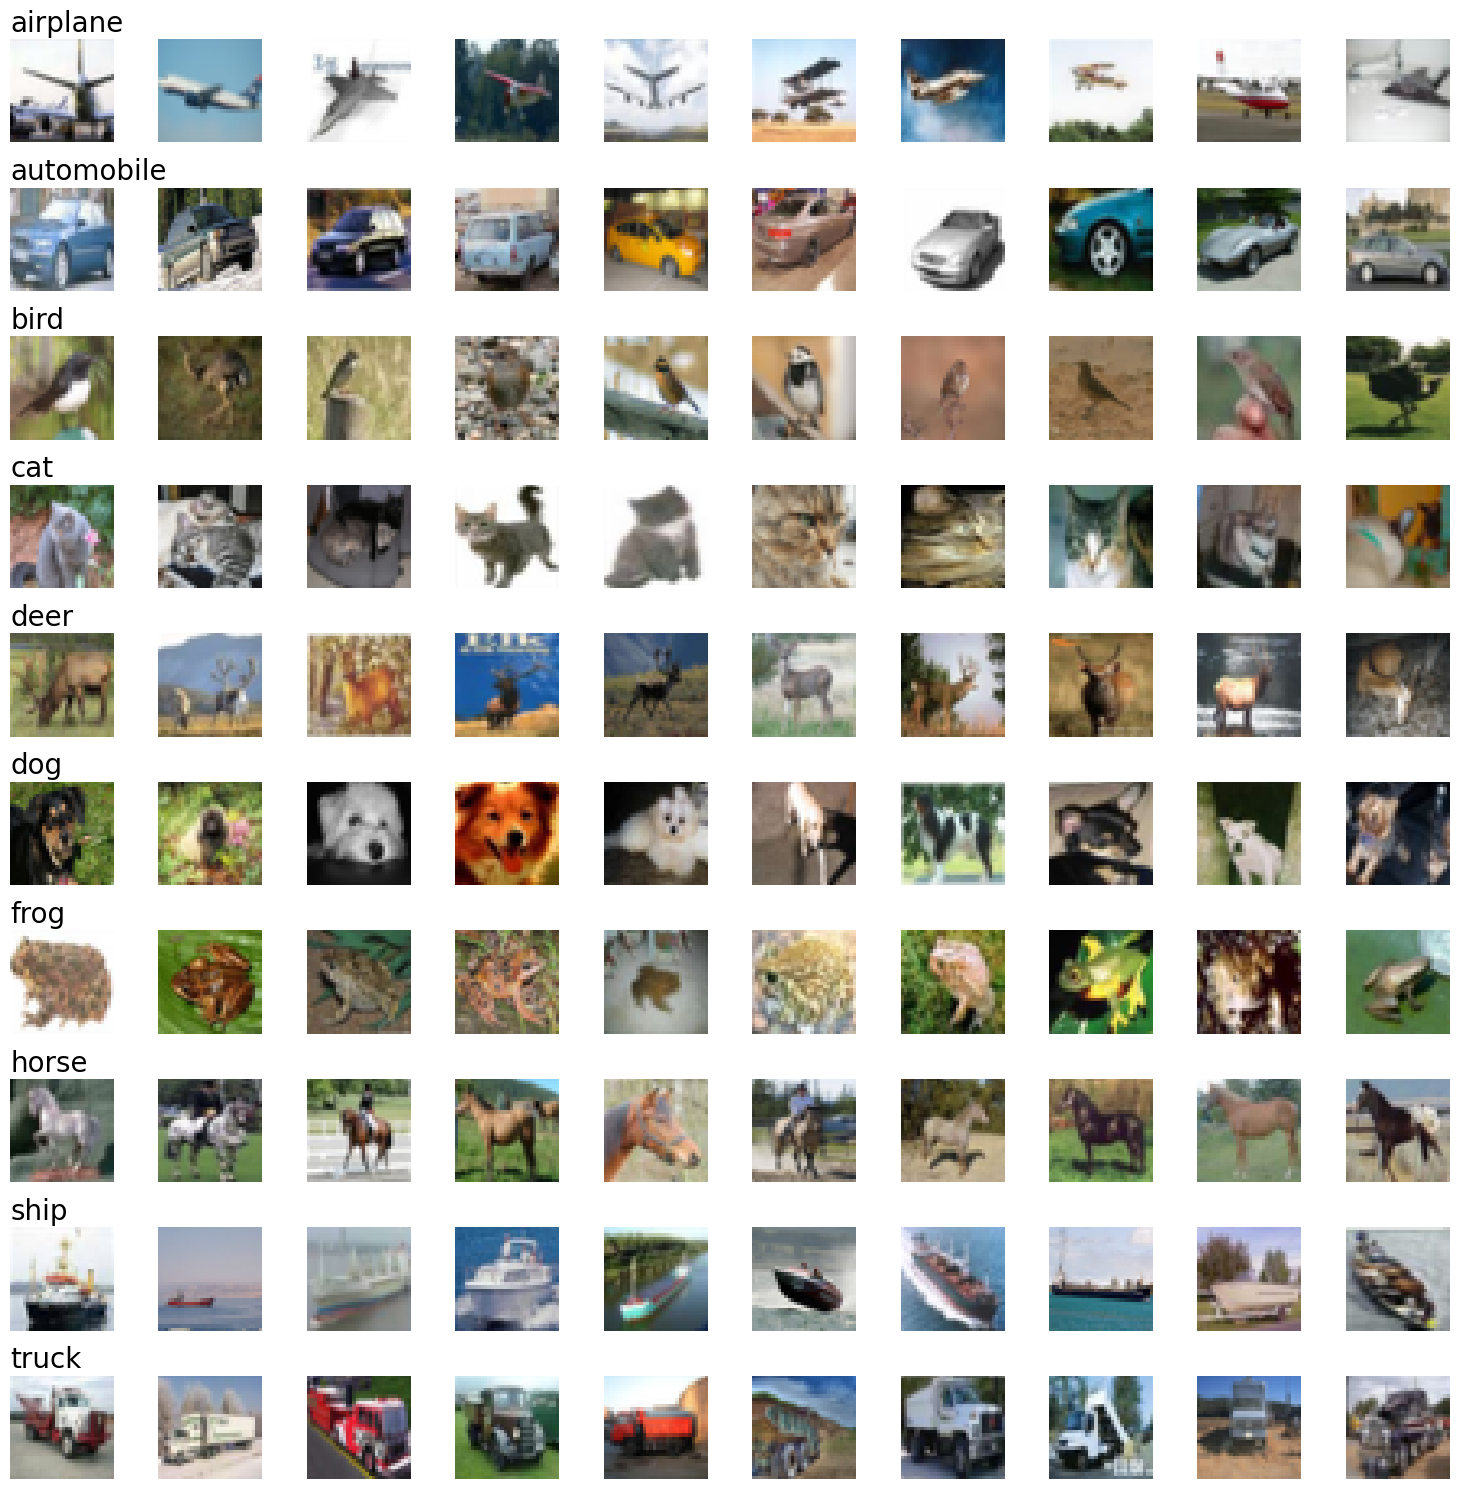

In [23]:
# Number of samples to display per class
num_samples = 10

# Create a figure
fig, axes = plt.subplots(len(LABEL_NAMES), num_samples, figsize=(15, 15))

# Iterate over each class
for class_idx, class_name in enumerate(LABEL_NAMES):
    # Find the indices of images belonging to the current class
    class_indices = np.where(y_train.flatten() == class_idx)[0]

    # Randomly select `num_samples` images from the class
    selected_indices = np.random.choice(class_indices, num_samples, replace=False)

    # Plot the images
    for i, img_idx in enumerate(selected_indices):
        ax = axes[class_idx, i]
        ax.imshow(x_train[img_idx])
        ax.axis("off")
        if i == 0:  # Add class name only on the first image
            ax.set_title(class_name, fontsize=20, loc="left")

# Adjust layout and display
plt.tight_layout()
plt.show()

## PARTITION TRAINING INTO VALIDATION
Dataset comes with
- training set (50,000)
- test set (10,000)

Now split training set into:
- trainng set
- validation set

Rationale:
- *** Research here as to correct size.
- 10%, 20%?????

Result:
- training set ()
- validation set ()
- test set (10,000)

In [20]:
# Split the training data into training and validation sets
x_train, x_validate, y_train, y_validate = train_test_split(
    x_train, y_train, test_size=0.2, random_state=0)

# Check the new shapes
print(f"New training data shape: {x_train.shape}")
print(f"Validation data shape: {x_validate.shape}")
print(f"New training labels shape: {y_train.shape}")
print(f"Validation labels shape: {y_validate.shape}")

New training data shape: (25600, 32, 32, 3)
Validation data shape: (6400, 32, 32, 3)
New training labels shape: (25600, 1)
Validation labels shape: (6400, 1)
